## Prediction of Heart Failure Mortality using Machine Learning Models

**Heart Failure** is a leading cause of morbidity and mortality in the United States.  It is estimated that 6.5 million Americans have heart failure, and 1 in 5 deaths are due to heart failure.  This is a complex condition that is influenced by a variety of risk factors, including age, gender, race, and genetics.  

**Keywords:** biomarkers, gene expression, heart failure, patient readmission, prognosis

**Next Steps:** While this notebook is focused on prediction of mortality to start with, we can also use the same data to predict diagnosis and prognosis. We will extend this notebook to multimodal data incorporating visual features and notes provided by the clinicians.

### Data Exploration

 Cliclinal Data used is obtained from  [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records). where each row represents a single patient and each column represents a clinical feature.  Decriptions of each feature can be found in the orignal paper [Ahmad *et al.* 2017](https://doi.org/10.1371/journal.pone.0181001) as well as [Chicco and Jurman 2020](https://doi.org/10.1186/s12911-020-1023-5). The last column, labeled **death_event** indicates whether the condition was fatal for the patient. 

#### Data Exploration - Box Plot

In [1]:
#### Feature Boxplot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# loading the dataset and displaying the first 10 rows
df = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")
print(df.head(10))

# all features except the last column (DEATH_EVENT)
feature_columns = df.iloc[:, :-1]

# the target is the last column
target_column = df.iloc[:, -1]

#remove non-clinal features
df.drop(columns=['time'], inplace=True)

print("Shape of df:", df.shape)
print("Shape of Feature Columns:", feature_columns.shape)
print("Shape of y:", target_column.shape)

# Plotting the box plot for each column
for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(3, 2)) # Create a new figure for each plot
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/heart_failure_clinical_records_dataset.csv'

#### Data Exploration - Pair Plot

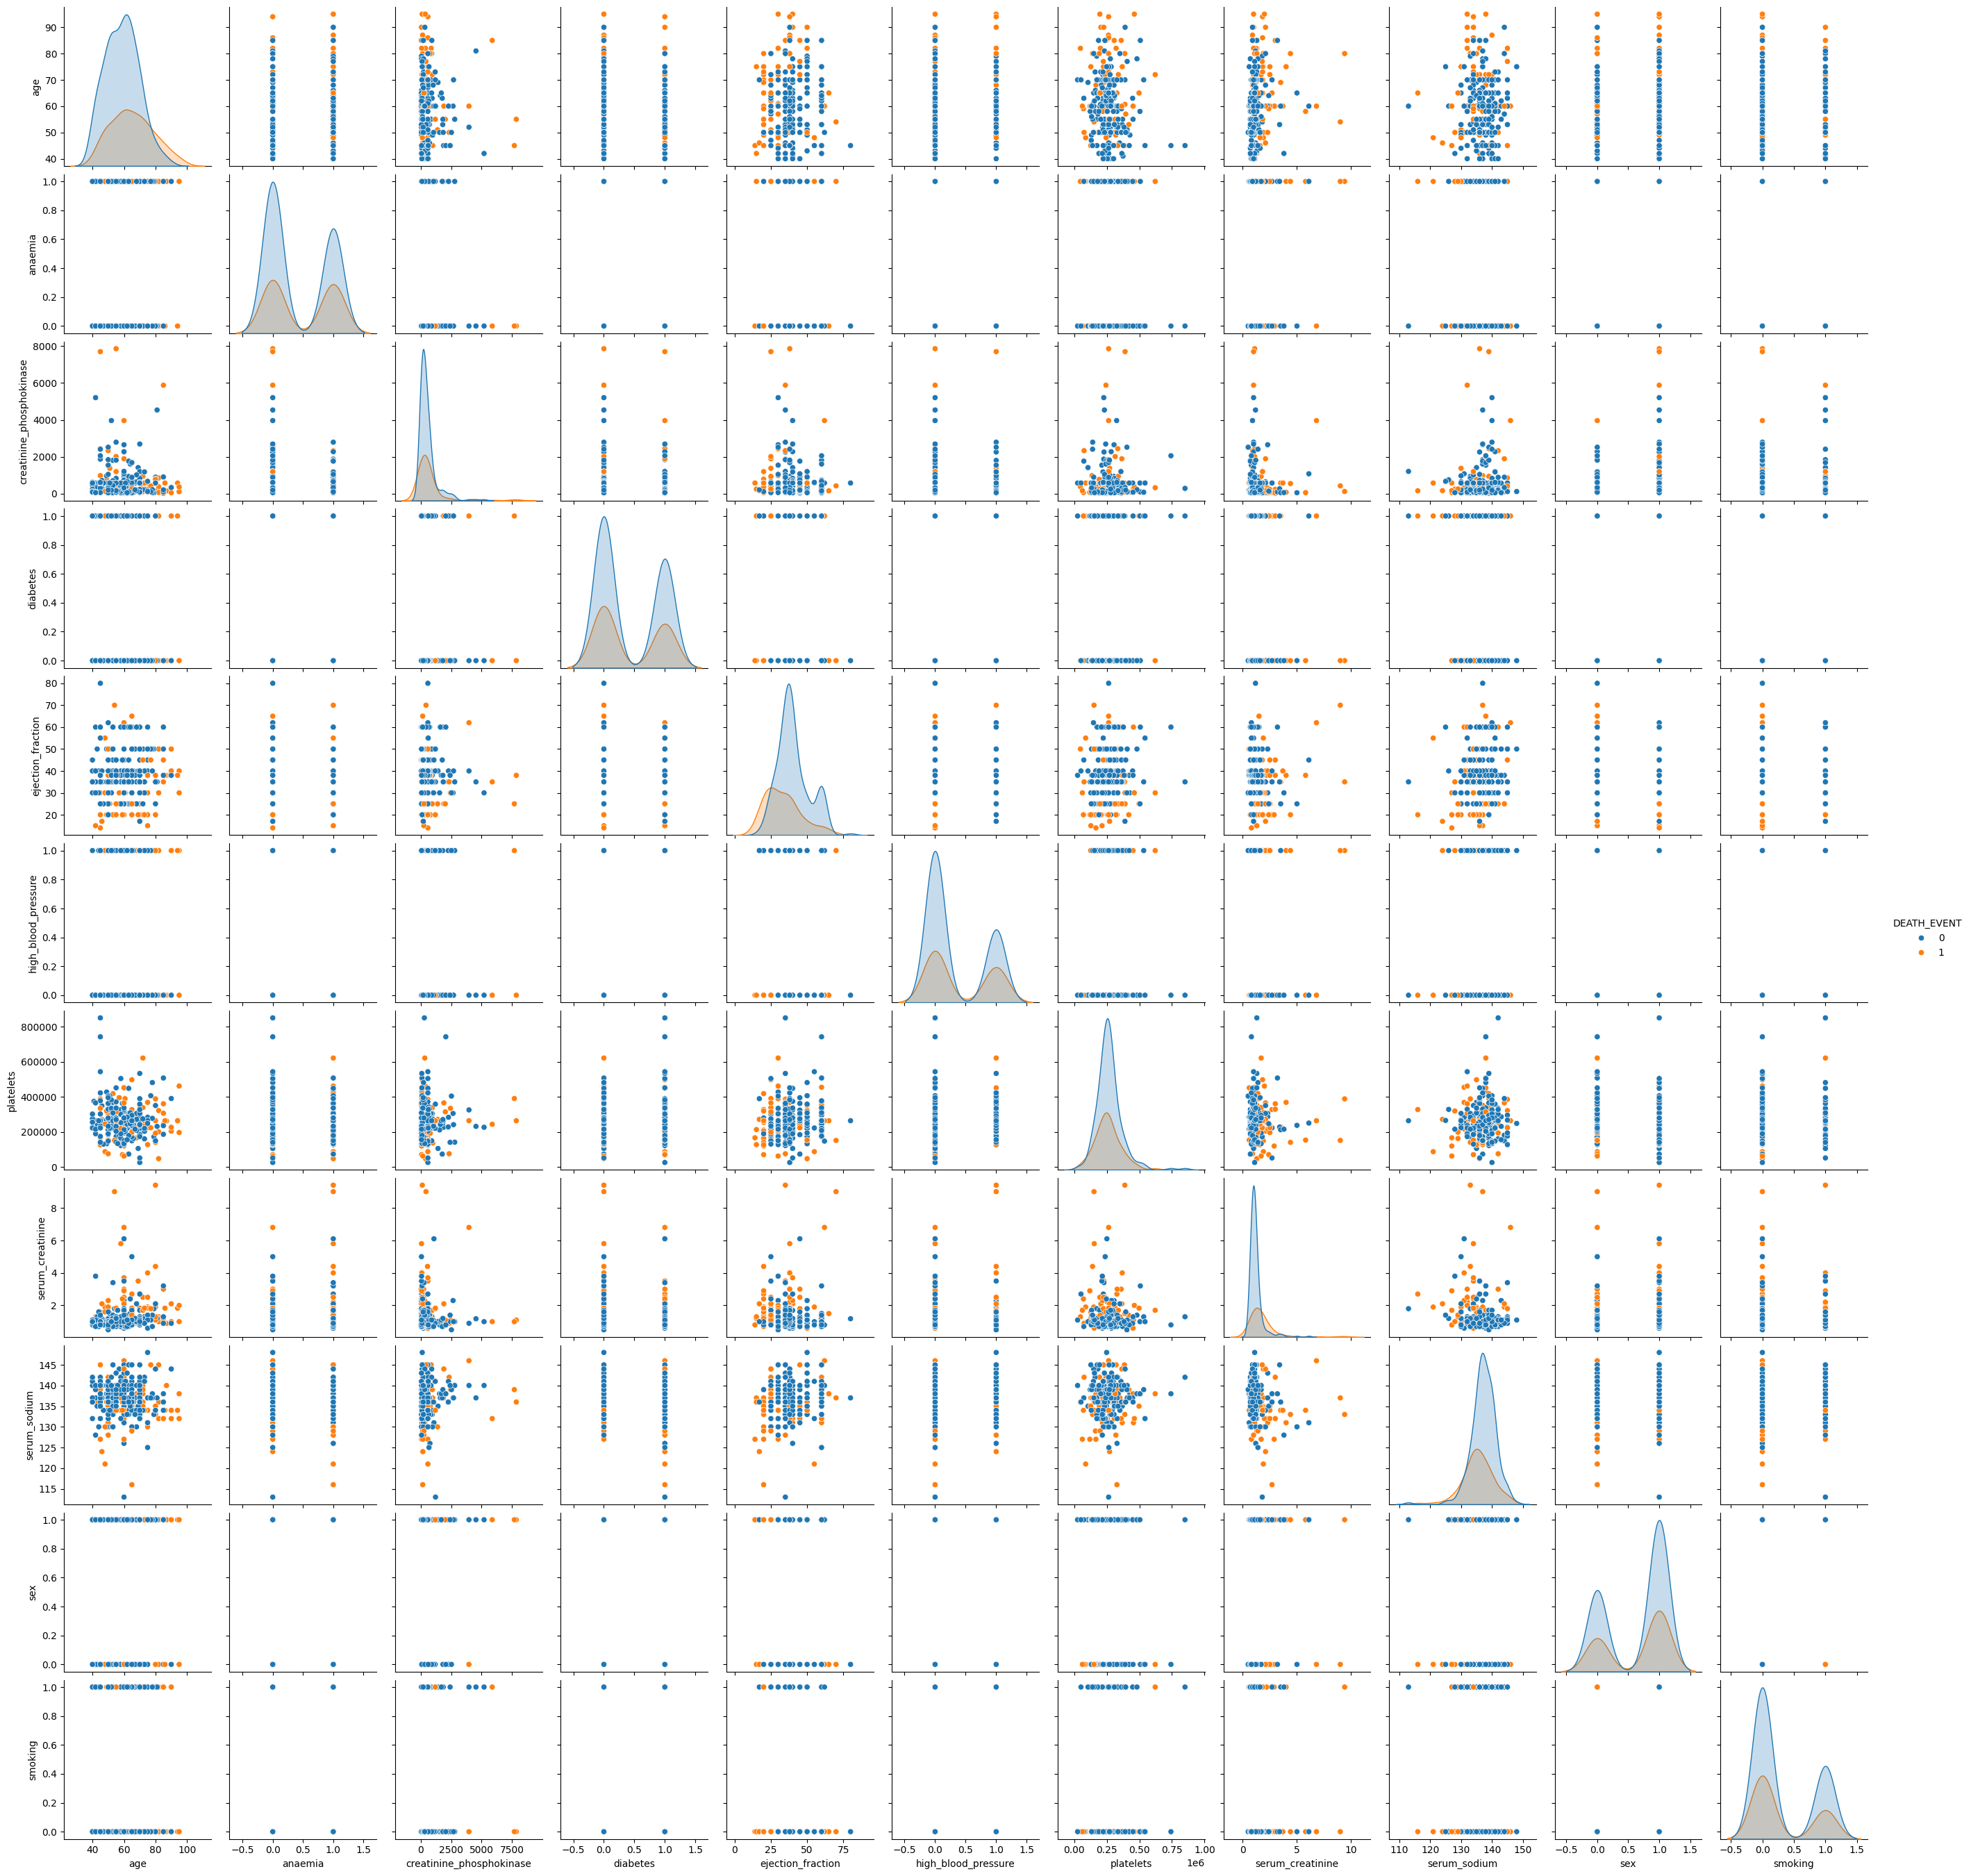

In [ ]:
#Plot pairplot with hue as DEATH_EVENT
sns.pairplot(df, hue='DEATH_EVENT')

#### Data Exploration - Feature Correlation Heatmap

<Axes: >

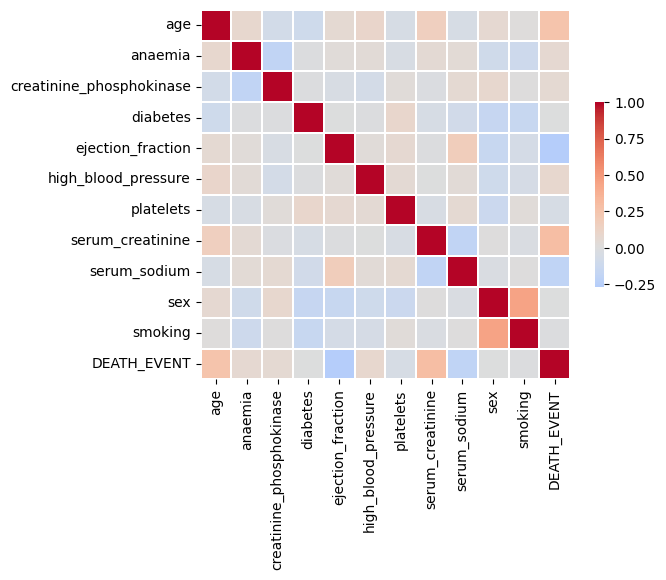

In [ ]:


# computing correlation matrix of the dataset and using seaborn to visualize it.
correlation = df.corr()
sns.heatmap(correlation, cmap='coolwarm', center=0, annot=False, square=True, linewidths=.15, cbar_kws={"shrink": .5})


### Data Exploration -Correlation Coefficent 

Here we look at the relationships clinical features to get a general idea of how features relate to each other.

Percentage of fatal cases: 32.1%


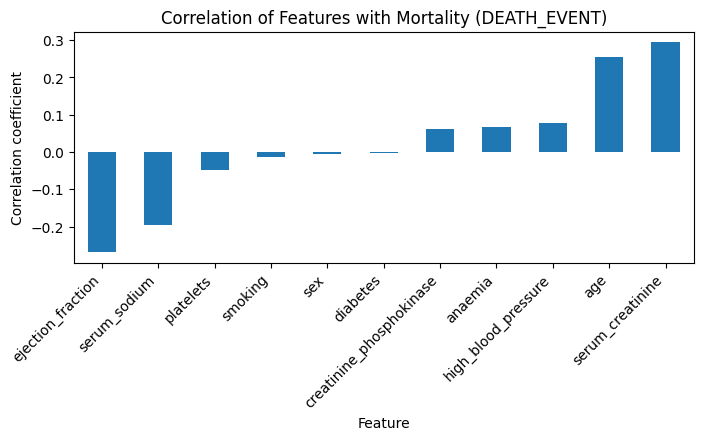

In [ ]:
# the fatal cases performance
fatal_percentage = target_column.mean() * 100
print(f"Percentage of fatal cases: {fatal_percentage:.1f}%")

# feature correlations with the target
correlations = df.corr(numeric_only=True)["DEATH_EVENT"].drop("DEATH_EVENT")

plt.figure(figsize=(8,3))
correlations.sort_values().plot(kind="bar")
plt.title("Correlation of Features with Mortality (DEATH_EVENT)")
plt.ylabel("Correlation coefficient")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.show()


### Data Standardization 

Numerical columns in features in have very different magnitudes. When training the a model, columns with larger magnitudes can dominate the learning process and bias the model towards those features. Therefore, we apply **standardization** of features to produce a less biased model. After standardizing the columns, values will be transformed, and each column would have **zero mean** (mean or average = 0) and **unit variance** (variance = 1).  This is equivelant to converting each features values to it's corresponding **z-score**.

* We will use sklearn's `StandardScaler` to standardize these columns and then display the first 10 rows of the results of standardization.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_columns)

X_scaled = pd.DataFrame(X_scaled, columns=feature_columns.columns)

# checking the first 10 standardized rows
print(X_scaled.head(10))

        age   anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  1.192945 -0.871105                  0.000166 -0.847579          -1.530560   
1 -0.491279 -0.871105                  7.514640 -0.847579          -0.007077   
2  0.350833 -0.871105                 -0.449939 -0.847579          -1.530560   
3 -0.912335  1.147968                 -0.486071 -0.847579          -1.530560   
4  0.350833  1.147968                 -0.435486  1.179830          -1.530560   
5  2.456114  1.147968                 -0.552141 -0.847579           0.162199   
6  1.192945  1.147968                 -0.346704 -0.847579          -1.953749   
7 -0.070223  1.147968                 -0.275472  1.179830           1.854958   
8  0.350833 -0.871105                 -0.438583 -0.847579           2.278147   
9  1.614001  1.147968                 -0.473683 -0.847579          -0.260991   

   high_blood_pressure     platelets  serum_creatinine  serum_sodium  \
0             1.359272  1.681648e-02          0

### Train-Test Split 

Using **`train_test_split`** to perform a train-test split on `X` and `y`
Since the diagnostic class is unbalanced, we can use one of the following proceses to ensure that fatal cases are evenly distrubuted amoung the train and test cases.

Note: Why is class imbalance a problem ?
1. Misleading Accuracy: A model can achieve 99% accuracy by simply predicting the majority (healthy) class every time if the disease prevalence is only 1%. This model would be useless for actual diagnosis.
2. Poor Sensitivity (Recall): Standard models tend to be overwhelmed by the majority class and ignore the minority class, resulting in a high rate of false negatives (missed diagnoses), which is a critical failure in healthcare applications.
3. Biased Models: The learning algorithm's loss function is typically dominated by the majority class, leading to a biased model that does not adequately learn the characteristics of the rare condition. 

Following strategies can be used to overcome this 
1. Resampling (a) Oversampling of minority class or (b) Undersampling of majority class or (c) Ensembling - combining sampling techniques with ensemble algorithms (like Random Forest or AdaBoost)

Here we will use  **`stratify`** option available through sklearn library. 

In [ ]:
from sklearn.model_selection import train_test_split

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.5, stratify=y, random_state=42
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Fatal cases in train:", y_train.mean()*100, "%")
print("Fatal cases in test:", y_test.mean()*100, "%")


Train set shape: (149, 11) (149,)
Test set shape: (150, 11) (150,)
Fatal cases in train: 32.21476510067114 %
Fatal cases in test: 32.0 %


### Training and Evaluating the Model

Using `LogisticRegression` from `sklearn.linear_model` to train a logistic regression model on the **training** data  
and then assesing the accuracy of this model on the **testing** data using `accuracy_score`.

random state=42 is a reference to hitchhiker's guide to galaxy. the random seed genefrator allows the results to be reproducible. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# actually creating and training the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# making predictions and then calculating the accuracy on the testing set
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Test Accuracy: {acc:.3f}")

Logistic Regression Test Accuracy: 0.727


### Refining Hyperparameters
A **hyperparameter** is a constant value that is specified before optimzation.

One of the primary hyperparameters is the regularization constant (Regularization in logistic regression is a technique used to prevent overfitting by adding a penalty to the model's loss function. ) $\lambda = \frac{1}{C}$. By default `LogisticRegression` uses a default value of $C=1$

 - Refining this model by estimating an optimal value for $C = \frac{1}{\lambda}$ using **k-fold Cross Validation** on the **training data**.  The funcion [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) from `sklearn.model_selection` splits the training data set into smaller class stratified chunks that can be fed into the model. 
 - Using $k=5$ splits (folds) and several values for $C \in [0.001, 1000]$, we will calculate the mean accuracy for each $C$ value across the folds.
 - The best $C$ value is the one with the highest accuracy!

In [ ]:
from sklearn.model_selection import StratifiedKFold

# defining the C values to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]

# cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_accuracies = []

for C in C_values:
    fold_accuracies = []

    # splitting the training set into 5 folds
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # training logistic regression with given C
        model = LogisticRegression(C=C, max_iter=1000, random_state=42)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        fold_accuracies.append(accuracy_score(y_val, preds))

    # the average accuracy across the 5 folds
    mean_accuracies.append(np.mean(fold_accuracies))

# finding the best C
zipped_data = zip(C_values, mean_accuracies)

# Convert to a pandas DataFrame with specified columns
df = pd.DataFrame(zipped_data, columns=['C_Value', 'Mean_Accuracy'])
print(df)
best_C = C_values[np.argmax(mean_accuracies)]
print("Best C value:", best_C)

    C_Value  Mean_Accuracy
0     0.001       0.677931
1     0.010       0.684598
2     0.100       0.698391
3     1.000       0.772184
4    10.000       0.772184
5   100.000       0.772184
6   500.000       0.772184
7  1000.000       0.772184
Best C value: 1


### Retraining Model with Best regularization Hyperparameter

In [ ]:
# training logistic regression again on the full training set with the best C
best_log_reg = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
best_log_reg.fit(X_train, y_train)

# evaluating accuracy on test set
y_pred_best = best_log_reg.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print(f"Test Accuracy with best C={best_C}: {acc_best:.3f}")

Test Accuracy with best C=1: 0.727


### Logistic Regression Coefficients
The coefficients vector $\hat \beta$ from the model tells us the prediction of how feature in $X$ relates to the target $y$. If $\hat \beta_k > 0$  then the $k$th feature is predicted to increase the likelyhood of heart failure while $\hat \beta_k < 0$ decreases the likehood.

Using model's `.coef[0]` attribute to make a bar graph of the coefficient values for each feature

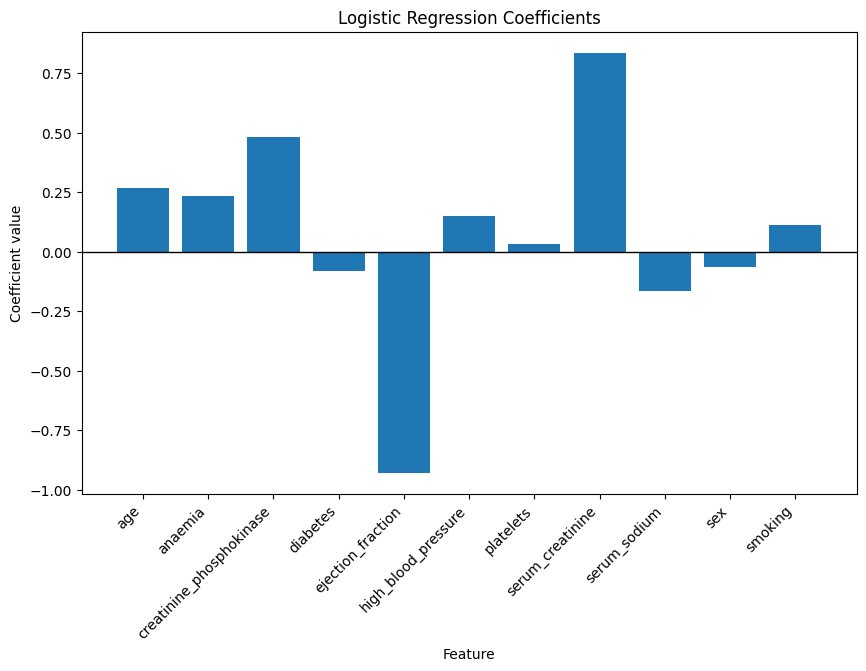

In [ ]:
# each coefficient corresponds to one feature in X
# a positive coefficient increases the chance of a fatal event while a negative coefficient decreases the chance.
coefficients = best_log_reg.coef_[0]

plt.figure(figsize=(10,6))
plt.bar(X_train.columns, coefficients)
plt.axhline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients")
plt.ylabel("Coefficient value")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.show()